In [1]:
import pickle
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
from experiments import run_experiments

# The Data
## Log-Normal Distribution
In order to simulate an annoying real-world distribution, I used the log-normal distribution and rounded the results

This causes a large number of uniques, but with heavy-hitters and several lower probability uniques that still show up several times

## Sample Random Seed
To generate the same sample on several runs, I just used my id as the random seed.

## Sample size
I choose to use 200,000 (2e5) samples, since it's a nice round number.


In [3]:
X = lognorm.rvs(5, size=int(2e5), random_state=206783441).astype(int)

## Number of unique values
With the chosen seed I got 12147 unique values - which matches the criteria of 10k uniques

In [4]:
np.unique(X).shape

(12147,)

## How the distributions looks
We can see what I mean - many heavy hitters close to 0, but plenty of uniques

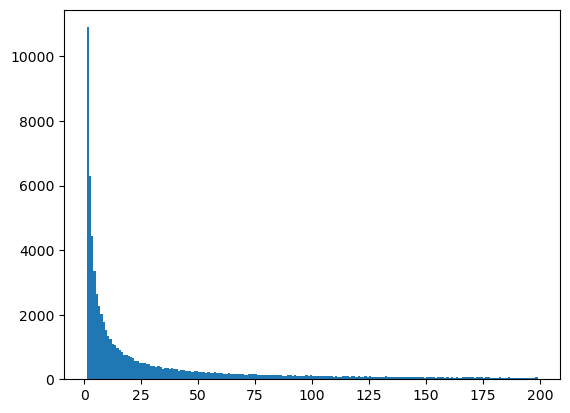

In [5]:
plt.hist(X, bins=np.arange(1, 200))
plt.show()

# Experiments


## The pre-processing trick
In order to save myself time, I decided to calculate the minimal hash value for 100,000 different unique random seeds,\
which then allows me to 'run' fm without much cost with hash functions matching those seeds.

In [11]:
min_hashes_dict: dict[int, float] = pickle.loads(Path('min_hashes_dict.pkl').read_bytes())

## Parameters
I ran 100 different experiments for each estimator and config, with the seeds being the values 1 to 100 for each one.

I used the seed to init the random hash function (the way it works is further elaborated in the file `experiments.py`) and besides that everthing else is deterministic

## Single $\alpha$ estimator
Here I could use the fact that I already have 100,000 min hashes to run 100,000 experiments with a single $\alpha$ estimator - so why not?

In [12]:
alpha_results = [1.0 / v for v in min_hashes_dict.values()]

### The results
We can already see that median is really far from the actual value (around 5000 off)

In [16]:
np.median(alpha_results)

np.float64(17798.525583497176)

The mean is even worse, most likely due to outliers (as we'll see later)

In [17]:
np.mean(alpha_results)

np.float64(216280.76118170455)

The normalized variance is also insane - it's more than 9 billion

In [19]:
np.var(alpha_results) / len(np.unique(X))

np.float64(9435443748.274153)

when we plot a histogram of the values with the actual number of uniques, the mean, and the median - we can see that they are not even close!

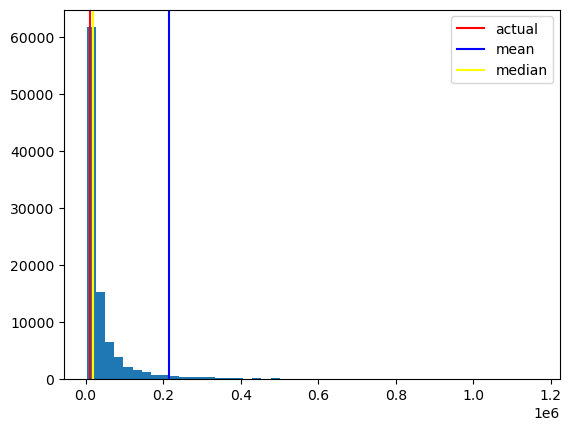

In [21]:
plt.hist(alpha_results, bins=np.linspace(np.quantile(alpha_results, 0.01), np.quantile(alpha_results, 0.99)))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

If we zoom in a bit, we can see that the median has most values around it, while the actual value is the **36th percentile!**

In [22]:
np.mean(np.array(alpha_results) <= len(np.unique(X)))

np.float64(0.36689)

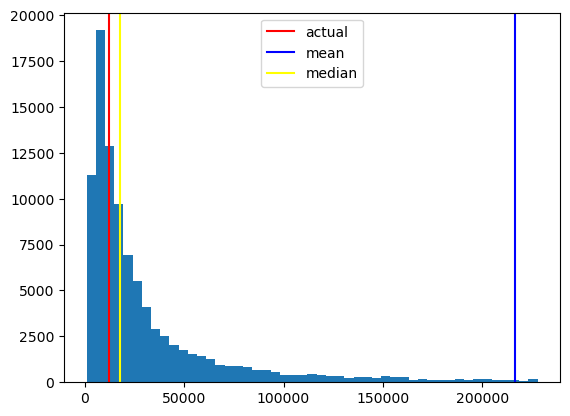

In [23]:
bins = np.linspace(np.min(alpha_results), np.quantile(alpha_results, .95)).tolist()
plt.hist(alpha_results, bins=sorted(bins))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

this shows that as we learned at class, the $\alpha$ estimator has way too much variance to be used as is

## Single $\beta$ estimator
Here I ran a full FM estimator with a several hash functions and a single $\beta$ estimator - which is just a $\beta$ estimator

For the beta estimator, I ran the same number of experiments with the following sketch sizes matching values of $\epsilon$ and $\delta$:
| $\delta$           | $\epsilon$     | sketch size |
|--------------------|----------------|-------------|
| 0.50 | 0.25 | 32 |
| 0.33 | 0.25 | 48 |
| 0.50 | 0.20 | 50 |
| 0.25 | 0.25 | 64 |
| 0.33 | 0.20 | 75 |
| 0.20 | 0.25 | 80 |
| 0.25 | 0.20 | 100 |
| 0.20 | 0.20 | 125 |
| 0.10 | 0.25 | 160 |
| 0.50 | 0.10 | 200 |
| 0.10 | 0.20 | 250 |
| 0.33 | 0.10 | 300 |
| 0.05 | 0.25 | 320 |
| 0.25 | 0.10 | 400 |
| 0.20 | 0.10 | 500 |
| 0.50 | 0.05 | 800 |
| 0.10 | 0.10 | 1000 |

In [44]:
beta_sketch_sizes = [32, 48, 50, 64, 75, 80, 100, 125, 160, 200, 250, 300, 320, 400, 500, 800, 1000]

### Other Parameters
In this case I ran 100 experiments per sketch size so that I could better compare the results

In [54]:
def beta_experiment(experiment_seed: int, num_hash_funcs: int) -> float:
    return float(1.0 / np.mean([min_hashes_dict[i + experiment_seed * num_hash_funcs] for i in range(num_hash_funcs)])  - 1)

In [55]:
beta_results = {
    sketch_size: [beta_experiment(base_seed, sketch_size) for base_seed in range(100)] for sketch_size in beta_sketch_sizes
}

In [56]:
[f'{n_hashes=}: median={float(np.median(b_res))}, diff={abs(float(np.median(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: median=13507.356075667132, diff=1360.3560756671322',
 'n_hashes=48: median=12328.673571105322, diff=181.67357110532248',
 'n_hashes=50: median=12702.250282483656, diff=555.2502824836556',
 'n_hashes=64: median=12488.169664503035, diff=341.16966450303516',
 'n_hashes=75: median=12477.278801316676, diff=330.2788013166755',
 'n_hashes=80: median=12737.856842782883, diff=590.8568427828832',
 'n_hashes=100: median=12868.68700916858, diff=721.6870091685796',
 'n_hashes=125: median=12577.175060140833, diff=430.175060140833',
 'n_hashes=160: median=12233.565248907918, diff=86.56524890791843',
 'n_hashes=200: median=12435.626151107055, diff=288.6261511070552',
 'n_hashes=250: median=12353.283457693165, diff=206.28345769316547',
 'n_hashes=300: median=12198.683609721807, diff=51.68360972180744',
 'n_hashes=320: median=12170.42945632114, diff=23.429456321140606',
 'n_hashes=400: median=12275.612556304099, diff=128.6125563040987',
 'n_hashes=500: median=12240.39584389107, diff=93.39

In [57]:
[f'{n_hashes=}: mean={float(np.mean(b_res))}, diff={abs(float(np.mean(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: mean=14947.33888500074, diff=2800.3388850007395',
 'n_hashes=48: mean=13520.34075009292, diff=1373.3407500929206',
 'n_hashes=50: mean=13486.588686500254, diff=1339.588686500254',
 'n_hashes=64: mean=13305.665626083157, diff=1158.665626083157',
 'n_hashes=75: mean=12960.111601666416, diff=813.1116016664164',
 'n_hashes=80: mean=13118.127412278203, diff=971.1274122782033',
 'n_hashes=100: mean=13090.898476516668, diff=943.8984765166679',
 'n_hashes=125: mean=12931.28768118223, diff=784.2876811822298',
 'n_hashes=160: mean=12558.986808582133, diff=411.98680858213265',
 'n_hashes=200: mean=12567.45465263587, diff=420.45465263586993',
 'n_hashes=250: mean=12607.265747359797, diff=460.2657473597974',
 'n_hashes=300: mean=12522.601373550564, diff=375.60137355056395',
 'n_hashes=320: mean=12473.27185131494, diff=326.27185131493934',
 'n_hashes=400: mean=12445.772473508196, diff=298.7724735081956',
 'n_hashes=500: mean=12464.21244060358, diff=317.21244060358003',
 'n_hashes=800:

In [58]:
[f'{n_hashes=}: norm_var={float(np.var(b_res) / len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=32: norm_var=2564.06337389795',
 'n_hashes=48: norm_var=1438.1508877581334',
 'n_hashes=50: norm_var=1221.3135017877426',
 'n_hashes=64: norm_var=1042.5074643941625',
 'n_hashes=75: norm_var=830.2341921576381',
 'n_hashes=80: norm_var=907.6598532697018',
 'n_hashes=100: norm_var=486.3882274193747',
 'n_hashes=125: norm_var=582.7806845299523',
 'n_hashes=160: norm_var=408.3663740703813',
 'n_hashes=200: norm_var=303.26014720764215',
 'n_hashes=250: norm_var=280.3307060547873',
 'n_hashes=300: norm_var=223.3275266757712',
 'n_hashes=320: norm_var=216.5318124343677',
 'n_hashes=400: norm_var=206.45414718520811',
 'n_hashes=500: norm_var=138.5914261110298',
 'n_hashes=800: norm_var=86.46754086372098',
 'n_hashes=1000: norm_var=63.372108354370866']

### Histograms
By looking at the histograms with different numbers of $\alpha$ estimators, we can see how the variance trends lower and the mean gets closer to the actual number of unique elements.

With 1000 $\alpha$ estimators the difference between the median and the target is already visually indistinguishable, with the difference being only ~5.25.

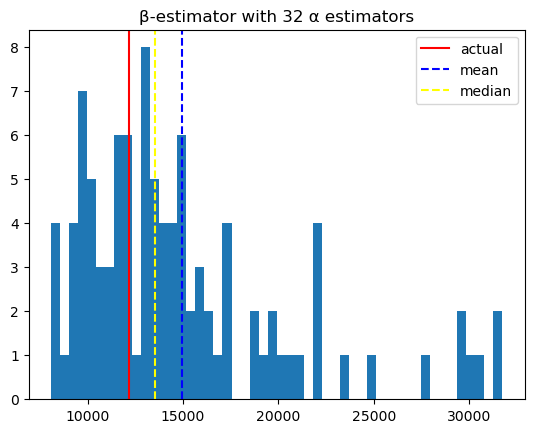

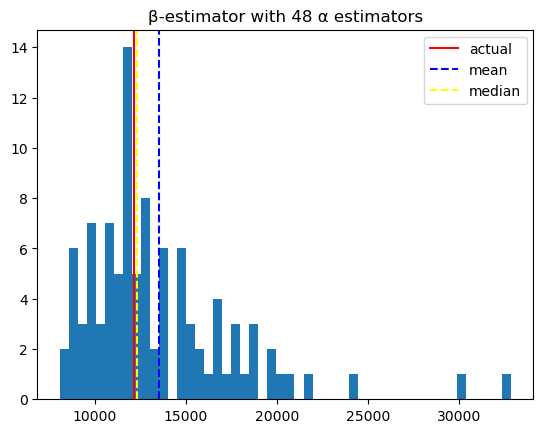

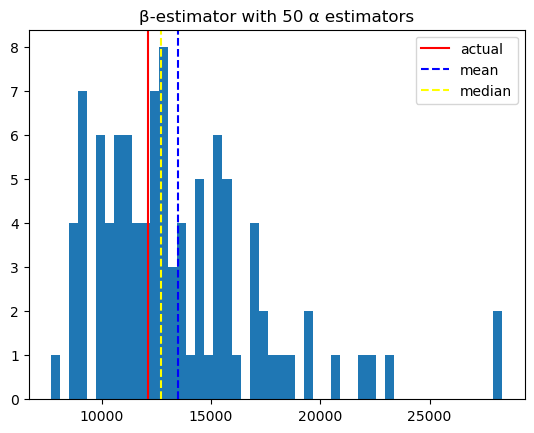

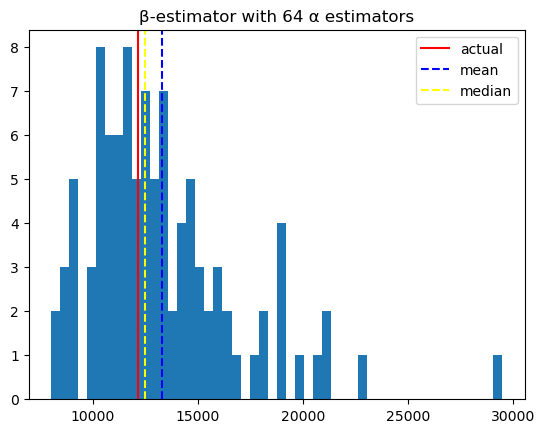

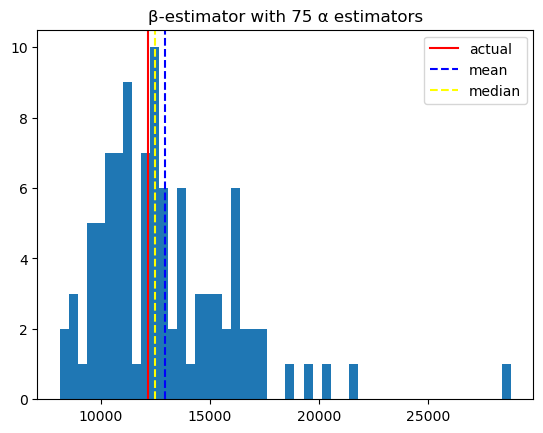

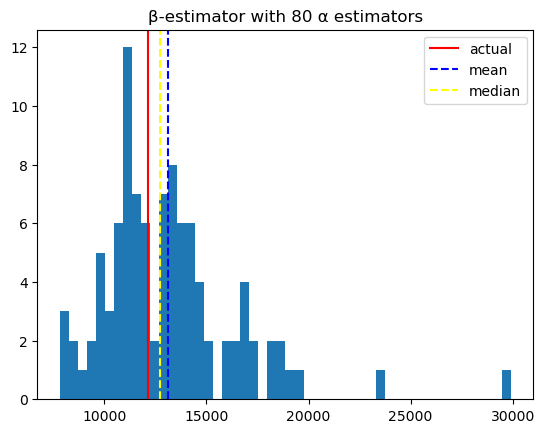

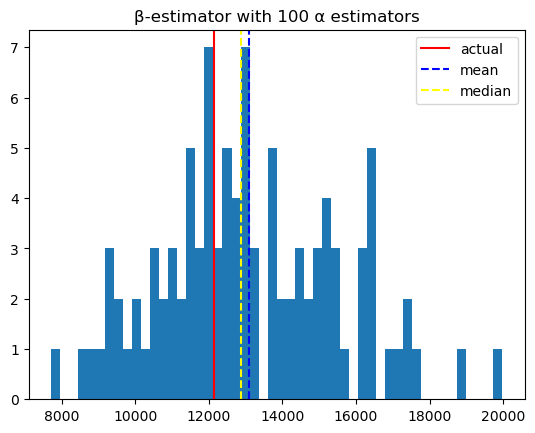

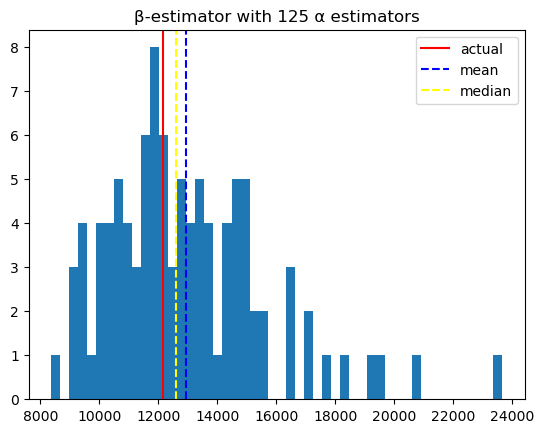

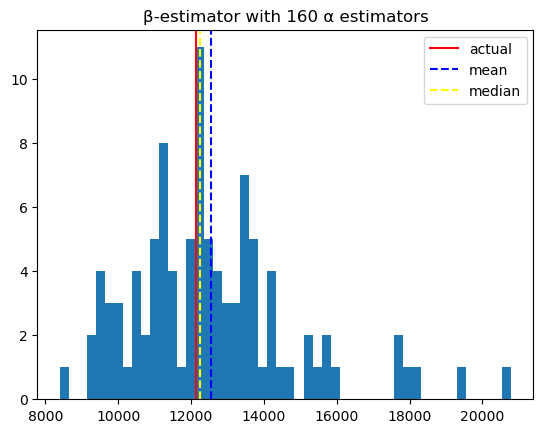

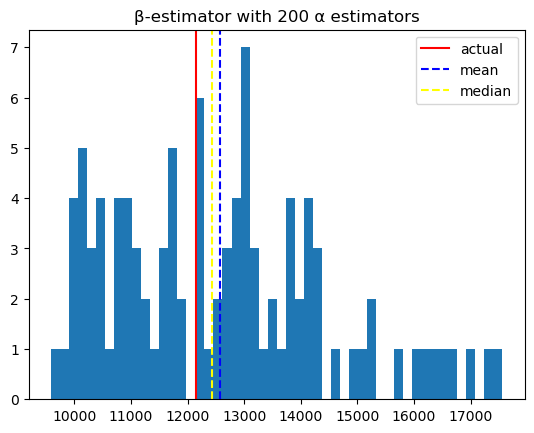

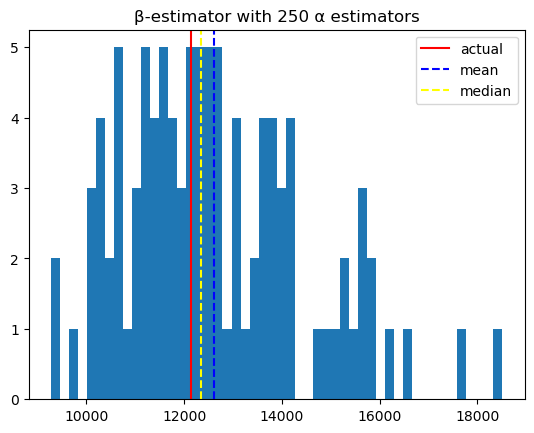

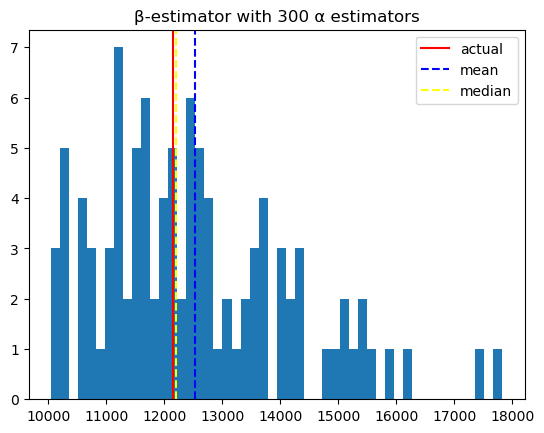

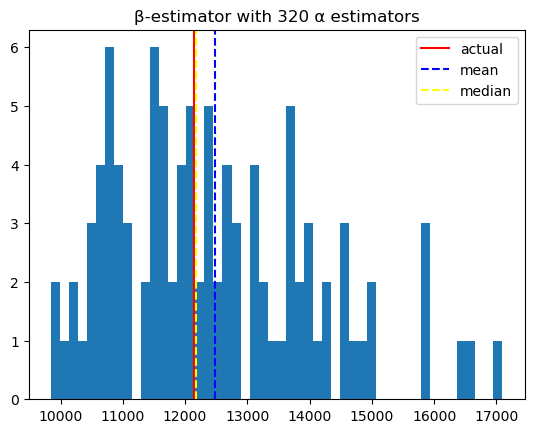

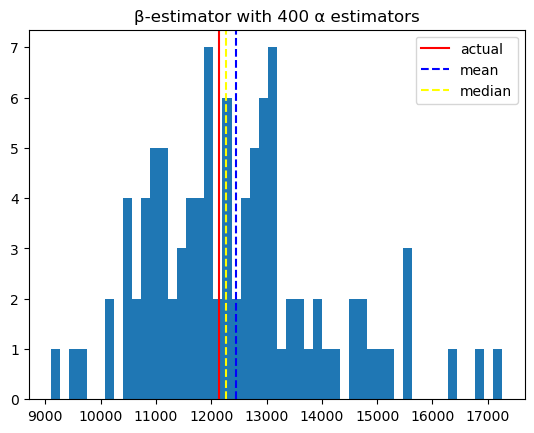

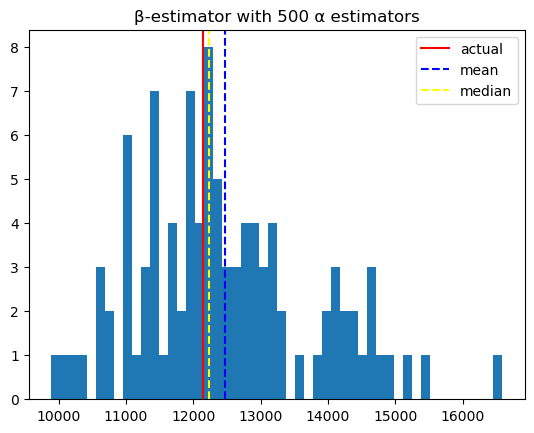

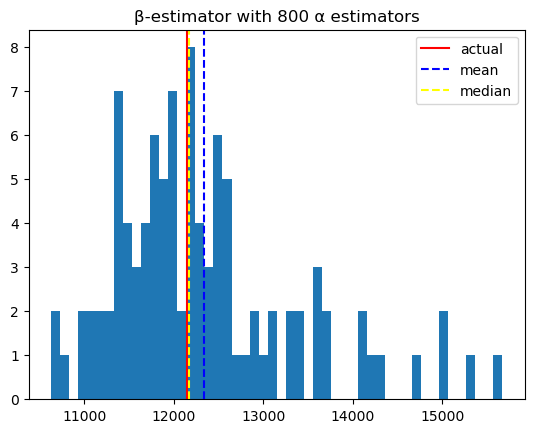

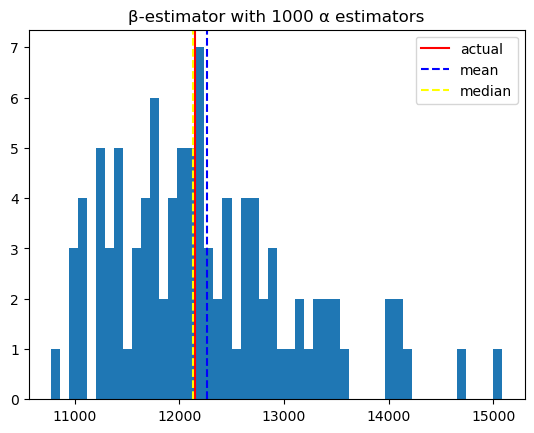

In [68]:
for n_hashes, b_res in sorted(beta_results.items()):
    fig = plt.figure()
    plt.hist(b_res, bins=50)
    plt.axvline(x=len(np.unique(X)), color='red', label='actual')
    plt.axvline(x=np.mean(b_res), color='blue', label='mean', linestyle='--')
    plt.axvline(x=np.median(b_res), color='yellow', label='median', linestyle='--')
    plt.title(f'β-estimator with {n_hashes} α estimators')
    plt.legend()
    plt.show()

### Mean as a function of the number of $\alpha$ estimators
We can see that the mean trends towards the actual value as the number of $\alpha$ estimators grows, which makes sense given what we learned in class

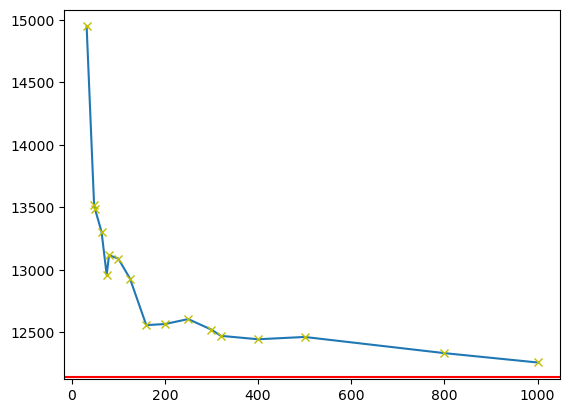

In [69]:
plt.plot(sorted(beta_results.keys()), [np.mean(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

### Median as a function of the number of $\alpha$ estimators
The median also trends towards the actual value as the number of $\alpha$ estimators grows, which is more interesting since this shows us what we could reasonably expect with the full FM estimator with 100 $\beta$ estimators

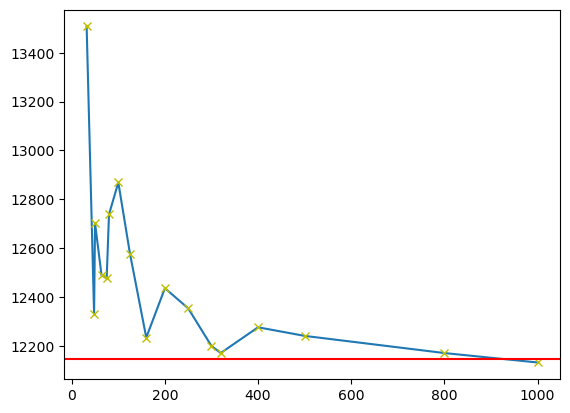

In [70]:
plt.plot(sorted(beta_results.keys()), [np.median(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

### Normalized Variance as a function of the number of $\alpha$ estimators
The normalized variance seems to decrease linearly as a function of the number of $\alpha$ estimators, which matches what we learned in class

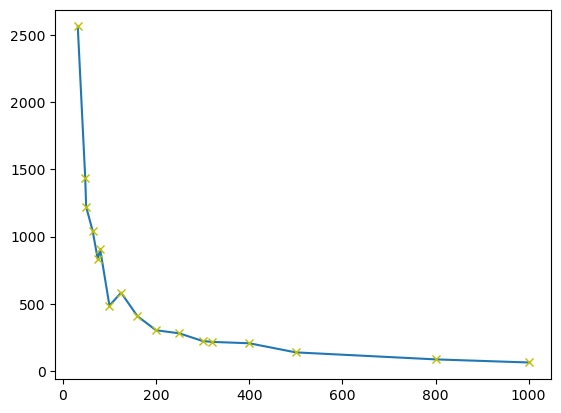

In [71]:
plt.plot(sorted(beta_results.keys()), [np.var(beta_results[k]) / len(np.unique(X)) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.show()

In [72]:
{k: np.var(val) / len(np.unique(X)) for k, val in beta_results.items()}

{32: np.float64(2564.06337389795),
 48: np.float64(1438.1508877581334),
 50: np.float64(1221.3135017877426),
 64: np.float64(1042.5074643941625),
 75: np.float64(830.2341921576381),
 80: np.float64(907.6598532697018),
 100: np.float64(486.3882274193747),
 125: np.float64(582.7806845299523),
 160: np.float64(408.3663740703813),
 200: np.float64(303.26014720764215),
 250: np.float64(280.3307060547873),
 300: np.float64(223.3275266757712),
 320: np.float64(216.5318124343677),
 400: np.float64(206.45414718520811),
 500: np.float64(138.5914261110298),
 800: np.float64(86.46754086372098),
 1000: np.float64(63.372108354370866)}

## Full FM estimator


Here I ran a full FM estimator with 100 experiments with the following params:

| $\delta$ | $\epsilon$ | #$\beta$-estimators | Hash Functions |
|----------|------------|---------------------|----------------|
| 0.10     | 0.20       | 3                   | 58             |
| 0.05     | 0.20       | 3                   | 75             |
| 0.10     | 0.15       | 3                   | 103            |
| 0.01     | 0.20       | 5                   | 116            |
| 0.05     | 0.15       | 3                   | 134            |
| 0.01     | 0.15       | 5                   | 205            |
| 0.10     | 0.10       | 3                   | 231            |
| 0.05     | 0.10       | 3                   | 300            |
| 0.01     | 0.10       | 5                   | 461            |
| 0.10     | 0.05       | 3                   | 922            |
| for fun  | for fun    | 3                   | 1000           |
| for fun  | for fun    | 5                   | 1000           |

In [91]:
full_sketches = [(3, 58), (3, 75), (3, 103), (5, 116), (3, 134), (5, 205), (3, 231), (3, 300), (5, 461), (3, 922), (3, 1000), (5, 1000)]

In [88]:
from typing import Iterable, Sequence, TypeVar

T = TypeVar("T")

def calculate_chunk_sizes(seq_len: int, num_chunks: int) -> list[int]:
    res = np.zeros(num_chunks).astype(int)
    cur_len = num_chunks
    num_left = seq_len

    while np.sum(res) < seq_len:
        addition = num_left // cur_len
        if np.sum(res) + addition * cur_len <= seq_len:
            res[np.arange(cur_len)] += addition
            num_left -= addition * cur_len
        cur_len -= 1

    return res.tolist()

def chunk(vals: Sequence[T], num_chunks: int) -> Iterable[Sequence[T]]:
    cur_start = 0
    for chunk_size in calculate_chunk_sizes(len(vals), num_chunks):
        yield vals[cur_start:cur_start+chunk_size]
        cur_start += chunk_size

In [98]:
def full_fm_experiment(experiment_seed: int, num_betas: int, num_hash_funcs: int) -> float:
    min_hashes = [min_hashes_dict[i + experiment_seed * num_hash_funcs] for i in range(num_hash_funcs)]
    sub_betas = [1 / np.mean(beta_hashes) - 1 for beta_hashes in chunk(min_hashes, num_betas)]
    return float(np.median(sub_betas))

In [99]:
full_fm_results = {
    (n_betas, sketch_size): [full_fm_experiment(base_seed, n_betas, sketch_size) for base_seed in range(100)] for n_betas, sketch_size in full_sketches
}

In [105]:
sorted_full_fm_res = sorted(full_fm_results.items(), key=lambda x: x[0][1])

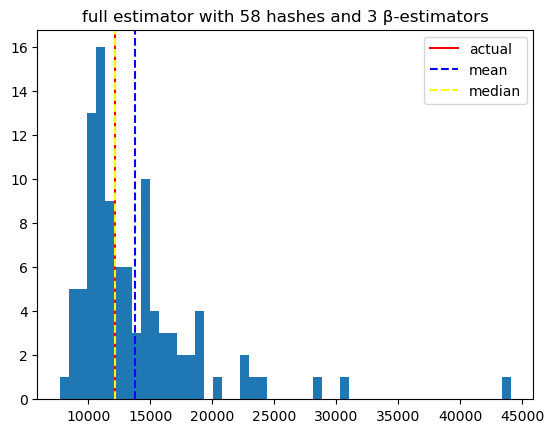

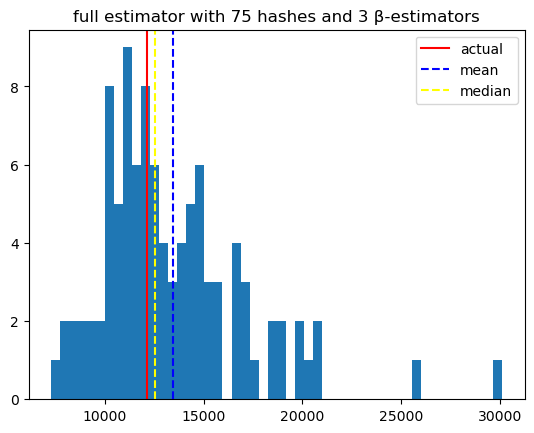

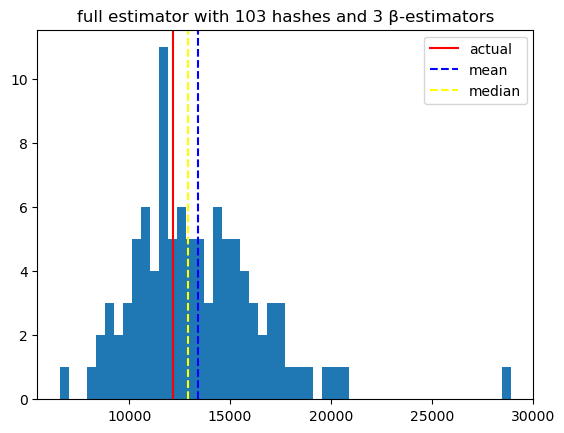

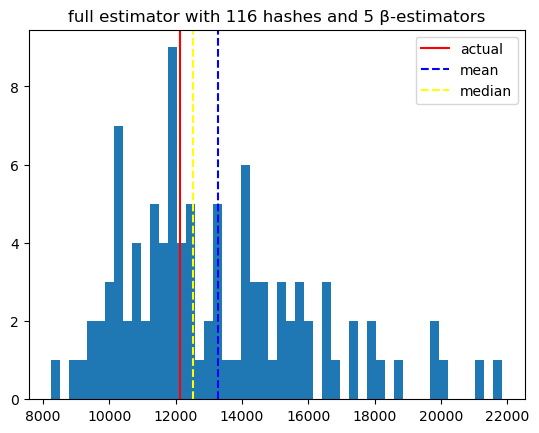

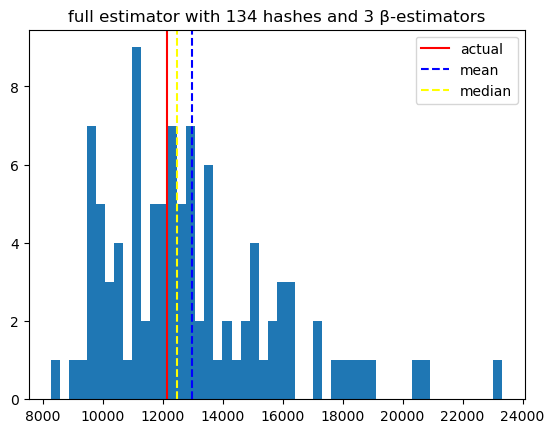

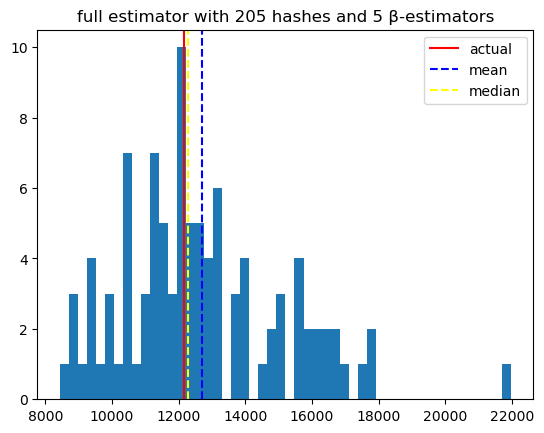

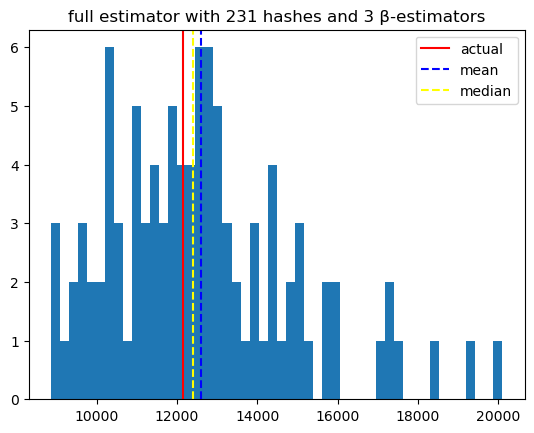

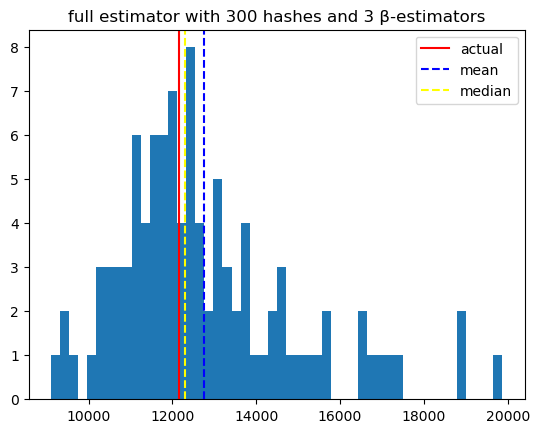

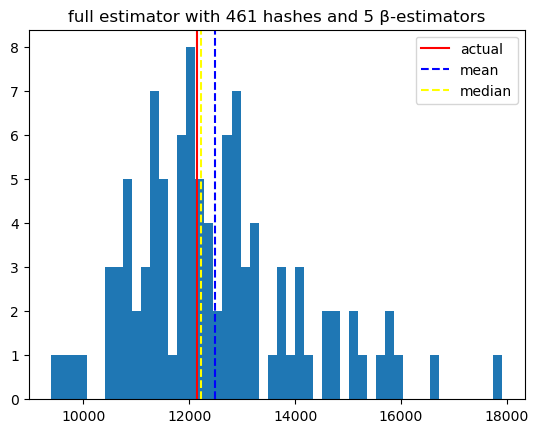

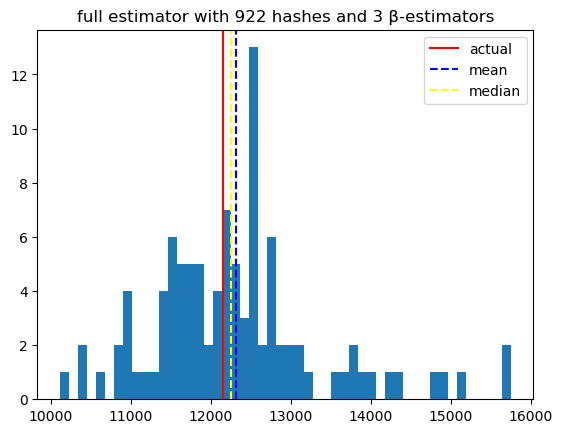

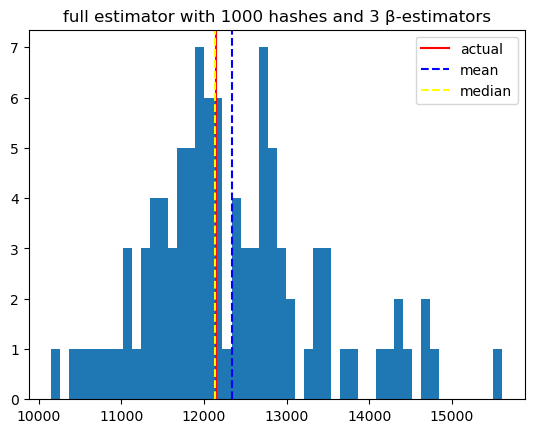

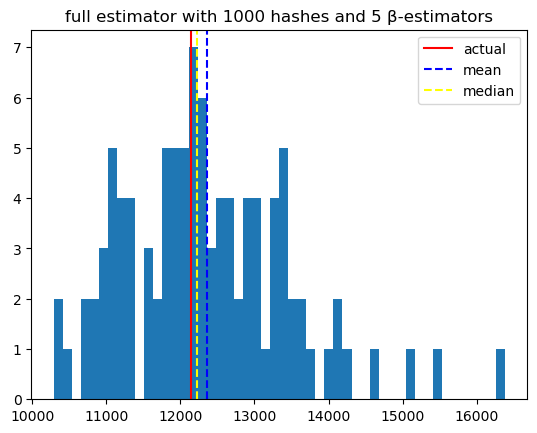

In [106]:
for (n_betas, n_hashes), b_res in sorted_full_fm_res:
    fig = plt.figure()
    plt.hist(b_res, bins=50)
    plt.axvline(x=len(np.unique(X)), color='red', label='actual')
    plt.axvline(x=np.mean(b_res), color='blue', label='mean', linestyle='--')
    plt.axvline(x=np.median(b_res), color='yellow', label='median', linestyle='--')
    plt.title(f'full estimator with {n_hashes} hashes and {n_betas} β-estimators')
    plt.legend()
    plt.show()

In [102]:
[f'{n_hashes=}, {n_betas=}: median={float(np.median(b_res))}, diff={abs(float(np.median(b_res)) - len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: median=12162.934306496807, diff=15.93430649680704',
 'n_hashes=75, n_betas=3: median=12544.31974563552, diff=397.3197456355192',
 'n_hashes=103, n_betas=3: median=12933.06423608301, diff=786.0642360830097',
 'n_hashes=116, n_betas=5: median=12539.725685386507, diff=392.7256853865074',
 'n_hashes=134, n_betas=3: median=12464.434003906601, diff=317.434003906601',
 'n_hashes=205, n_betas=5: median=12269.248919220267, diff=122.24891922026654',
 'n_hashes=231, n_betas=3: median=12405.012648208462, diff=258.01264820846154',
 'n_hashes=300, n_betas=3: median=12289.389810871393, diff=142.3898108713929',
 'n_hashes=461, n_betas=5: median=12221.065175116932, diff=74.06517511693164',
 'n_hashes=922, n_betas=3: median=12245.64436056234, diff=98.64436056234081',
 'n_hashes=1000, n_betas=3: median=12131.855749979622, diff=15.144250020377513',
 'n_hashes=1000, n_betas=5: median=12228.848831177398, diff=81.8488311773981']

In [103]:
[f'{n_hashes=}, {n_betas=}: mean={float(np.mean(b_res))}, diff={abs(float(np.mean(b_res)) - len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: mean=13790.64925853202, diff=1643.6492585320193',
 'n_hashes=75, n_betas=3: mean=13426.63210421069, diff=1279.6321042106902',
 'n_hashes=103, n_betas=3: mean=13408.349819654393, diff=1261.3498196543933',
 'n_hashes=116, n_betas=5: mean=13284.52130433138, diff=1137.5213043313797',
 'n_hashes=134, n_betas=3: mean=12970.628723447362, diff=823.6287234473621',
 'n_hashes=205, n_betas=5: mean=12683.46697675197, diff=536.4669767519699',
 'n_hashes=231, n_betas=3: mean=12603.132955431012, diff=456.1329554310123',
 'n_hashes=300, n_betas=3: mean=12761.233068659467, diff=614.2330686594669',
 'n_hashes=461, n_betas=5: mean=12487.59379916643, diff=340.5937991664305',
 'n_hashes=922, n_betas=3: mean=12317.223652289182, diff=170.2236522891817',
 'n_hashes=1000, n_betas=3: mean=12335.362797405216, diff=188.36279740521604',
 'n_hashes=1000, n_betas=5: mean=12360.10744583457, diff=213.10744583457017']

In [104]:
[f'{n_hashes=}, {n_betas=}: norm var={float(np.var(b_res) / len(np.unique(X)))}'
 for (n_betas, n_hashes), b_res in sorted_full_fm_res]

['n_hashes=58, n_betas=3: norm var=2160.7872326999804',
 'n_hashes=75, n_betas=3: norm var=1126.968916129423',
 'n_hashes=103, n_betas=3: norm var=858.0541349055981',
 'n_hashes=116, n_betas=5: norm var=676.9933997060745',
 'n_hashes=134, n_betas=3: norm var=649.8937122688274',
 'n_hashes=205, n_betas=5: norm var=489.2400774515316',
 'n_hashes=231, n_betas=3: norm var=433.3831659326632',
 'n_hashes=300, n_betas=3: norm var=363.63355599406225',
 'n_hashes=461, n_betas=5: norm var=204.76537168577005',
 'n_hashes=922, n_betas=3: norm var=92.50052839927672',
 'n_hashes=1000, n_betas=3: norm var=87.37341103319123',
 'n_hashes=1000, n_betas=5: norm var=101.71401576830868']

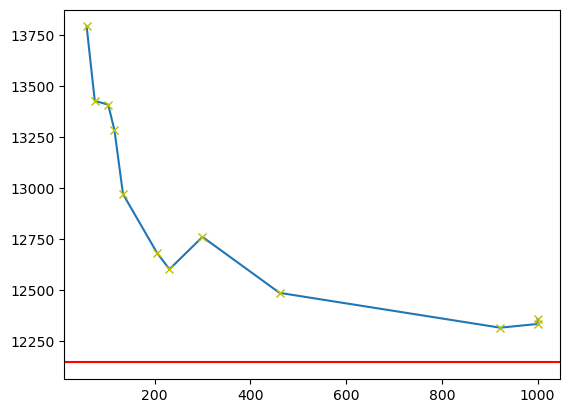

In [107]:
plt.plot(
    [sketch_size for (_, sketch_size), _ in sorted_full_fm_res],
    [np.mean(fm_res) for _, fm_res in sorted_full_fm_res], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()